# comment from shane
You should consider using multitaper estimates with Slepian (dpss) tapers. They have much better spectral characteristics and compared to the Welch’s method it allows you to estimate spectral density at the frequency/wavenumber corresponding to the total length of your data

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seawater as sw
from scipy import interpolate
from scipy import signal
from glob import glob
import scipy.ndimage
import matplotlib.colors as colors
from sklearn.linear_model import LinearRegression


#data directory for saildrone data
#more on the data here: https://podaac.jpl.nasa.gov/dataset/SAILDRONE_ATOMIC
# DOI = 10.5067/SDRON-ATOM0
data_dir = './../../paper_software/2020_ATOMIC_bjorn/data/'
saildrone_filenames = [x for x in glob(data_dir+'saildrone*.nc')]

#output
figs_dir = './figures/'

from spectrum import data_cosine, dpss, pmtm






# Read in USV data for all 3 Saildrone
- caluclate density and wind speed
- caluclate distance between successive obs
- caluculate total cumulative distance
- switch from time to cumulative distance as index
- interpolate data onto grid


In [2]:
ds=[]
for iusv in range(3):
    fname=saildrone_filenames[iusv]
    ds_usv=xr.open_dataset(fname).isel(trajectory=0).swap_dims({'obs':'time'})
    ds_usv.close()

#    #make diruanl plot
    xlon=ds_usv.longitude.data
    time_offset_to_lmt=(xlon/360.)*24.*60
    tem = ds_usv.time+time_offset_to_lmt*np.timedelta64(1,'m')# dt.timedelta(seconds=1)
    ds_usv['tlmt']=tem

    ds_usv2= ds_usv.swap_dims({'time':'tlmt'})
    ds_usv2a = ds_usv2.where(ds_usv2.tlmt.dt.hour==6)
    dymn = ds_usv2a.groupby("tlmt.dayofyear").mean()
    ds_usv3 = ds_usv2.groupby("tlmt.dayofyear") - dymn
   
    ds_usv['TEMP_AIR_MEAN_DW'] = ds_usv3.swap_dims({'tlmt':'time'}).drop({'tlmt'}).TEMP_AIR_MEAN
    ds_usv['TEMP_SBE37_MEAN_DW'] = ds_usv3.swap_dims({'tlmt':'time'}).drop({'tlmt'}).TEMP_SBE37_MEAN
    ds_usv['wspd']=np.sqrt(ds_usv.UWND_MEAN**2+ds_usv.VWND_MEAN**2)   
    tem=sw.dens0(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN)
    ds_usv['density_mean']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    tem=sw.alpha(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN,ds_usv.BARO_PRES_MEAN*0) #pressure =0 at surface
    ds_usv['alpha_ME']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    tem=sw.beta(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN,ds_usv.BARO_PRES_MEAN*0) #pressure =0 at surface
    ds_usv['beta_MEAN']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    ds_usv['latitude']=ds_usv.latitude.interpolate_na(dim='time')
    ds_usv['longitude']=ds_usv.longitude.interpolate_na(dim='time')
    xlat=ds_usv.latitude
    xlon=ds_usv.longitude
    dkm2 = abs(np.abs((((xlon[1:].data-xlon[0:-1].data)**2+(xlat[1:].data-xlat[0:-1].data)**2)**.5)*110.567*np.cos(np.pi*xlat[1:].data/180)))
    dkm2=np.append(dkm2,dkm2[66238]) #add on last point
    dkm3 = dkm2.cumsum()
    ds_usv['dist_total']=xr.DataArray(dkm3,dims=('time'),coords={'time':ds_usv.time})
    ds_usv['dist_between']=xr.DataArray(dkm2,dims=('time'),coords={'time':ds_usv.time})
    if iusv==0:
        ds = ds_usv
    else:
        ds = xr.concat([ds,ds_usv],dim='trajectory')
ds_saildrone = ds.copy(deep=True)


C:\Users\gentemann\Miniconda3\envs\test\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\test\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
C:\Users\gentemann\Miniconda3\envs\test\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\test\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
C:\Users\gentemann\Miniconda3\envs\test\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [3]:
#subroutines for calculating PSD & making plot
def spectrum(data_in):
    #calculate PSD for each USV
    data_all=[]
    for iusv in range(3):
        ds_usv = data_in.isel(trajectory=iusv)
        ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
        ds3 = ds2.swap_dims({'time':'dist_total'})
        dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],0.08)
        ds4 = ds3.interp(dist_total=dist_interp)
        den = ds4.density_mean.interpolate_na(dim='dist_total')
        den = den.where(np.isfinite(den),drop=True)
        ds4_detrend = signal.detrend(den)
        ds4_detrend_smooth = ds4_detrend
#        ds4_detrend_smooth = scipy.ndimage.filters.gaussian_filter1d(ds4_detrend, sigma=25)
        freq, Pxx_den = signal.periodogram(ds4_detrend_smooth,1/.080)  #fs = sampled at .08km or 80m
        freq2, Pxx_den2 = signal.welch(ds4_detrend_smooth,1/.080,nperseg=1024*30)  #fs = sampled at .08km or 80m
        if iusv==0:
            ps_all=Pxx_den[0:10000]
            ps_all_welch=Pxx_den2[0:10000]
        else:
            ps_all = np.vstack([ps_all,Pxx_den[0:10000]])
            ps_all_welch = np.vstack([ps_all_welch,Pxx_den2[0:10000]])    
    Pxx_den = np.mean(ps_all,axis=0)
    Pxx_den_welch = np.mean(ps_all_welch,axis=0)
    return freq,freq2,Pxx_den,Pxx_den_welch

freq_usv,freq2_usv,Pxx_den_usv,Pxx_den_welch_usv = spectrum(ds)



In [4]:
def cal_pdf(data_in): 
    #make arrays for sampling at different length scales
    length_scale = np.arange(.1,200,1)
    # create the empty data arrays to store the normalized histograms (normalized the *100 for percentage count)
    xx_in = np.arange(0,.2,.001)
    xx_in2 = np.arange(0,.2-.001,.001)
    data = np.zeros((len(length_scale),len(xx_in2)))
    ddn=xr.DataArray(data,dims=('length_scale','gradx'),coords={'length_scale':length_scale,'gradx':xx_in2})
    for iusv in range(3):
        ds_usv = data_in.isel(trajectory=iusv)
        ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)  #add dist traveled coordinate
        ds3 = ds2.swap_dims({'time':'dist_total'})                  #swap from time to distance traveled
        for ilen2,len2 in enumerate(length_scale):
            dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],len2)
            ds4 = ds3.interp(dist_total=dist_interp)       
            den_grad =  np.abs(np.gradient(ds4.density_mean)/len2)
            result,xx = np.histogram(den_grad,bins=xx_in)
            ddn[ilen2,:]=ddn[ilen2,:]+result
    for ilen2,len2 in enumerate(length_scale):
        ddn[ilen2,:]=ddn[ilen2,:]/sum(ddn[ilen2,:])*100  #normalize & turn into percent

    return ddn

ddn_usv = cal_pdf(ds)

200 200


C:\Users\gentemann\Miniconda3\envs\test\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\gentemann\Miniconda3\envs\test\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  # This is added back by InteractiveShellApp.init_path()


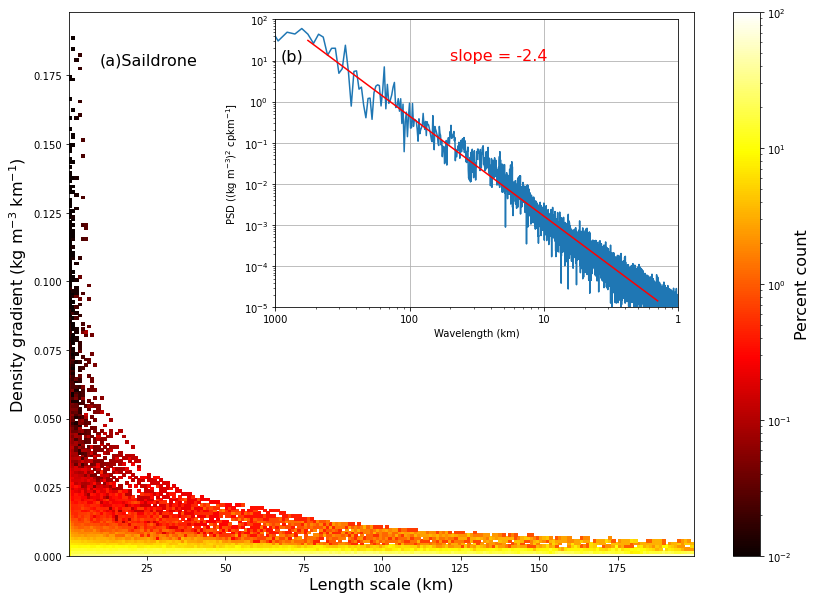

In [5]:
def psd_fig(f,data_in,Pxx_den,text1,fout,ifit):
   
    length_scale = np.arange(.1,200,1)
    xx_in = np.arange(0,.2,.001)
    xx_in2 = np.arange(0,.2-.001,.001)
    print(len(length_scale),len(xx_in))
    fig = plt.figure(figsize=(14,10))
    tem=data_in
    tem = tem.where(tem>.003)
    Z=tem.T
    ax = plt.pcolormesh(length_scale,xx_in2,Z, norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),vmin=.01,vmax=100,cmap='hot')
    plt.text(10,0.179,'(a)'+text1,fontsize=16,color='k')
    plt.xlabel('Length scale (km)',fontsize=16)
    plt.ylabel('Density gradient (kg m$^{-3}$ km$^{-1}$)',fontsize=16)
    cb = plt.colorbar()
    cb.set_label(label='Percent count',fontsize=16)

    plt.axes([.33, .47, .4, .4])

    #cal PSD
    #Pxx_den = np.mean(psd_in,axis=0)
    #f, Pxx_den = signal.periodogram(Pxx_den,1/.080)  #fs = sampled at .08km or 80m
    istart,iend=5,5550
    plt.loglog(f[istart:iend], Pxx_den[istart:iend])

    #linear regression to PSD
    istart,iend=10,ifit
    XX = np.log(f[istart:iend])
    YY = np.log(Pxx_den[istart:iend])
    reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
    a = float(reg.coef_)
    b = -1*float(reg.intercept_)
    plt.loglog(f[istart:iend], f[istart:iend]**(a)/np.exp(b),'r') #test from fit
    slp_str = 'slope = '+"{:.1f}".format(a)
    plt.text(.02,10,slp_str,fontsize=16,color='r')
    plt.ylim([10e-6,10e1])
    plt.xlim([10e-4,10e-1])
    plt.xticks(ticks=[.001,.01,.1,1],labels=['1000','100','10','1'])

    plt.text(.0011,10,'(b)',fontsize=16,color='k')
    #plt.xlabel('Wavenumber (cpkm)')
    plt.xlabel('Wavelength (km)')
    plt.ylabel('PSD ((kg m$^{-3}$)$^2$ cpkm$^{-1}$]')
    plt.grid()
    #plt.savefig(figs_dir+fout)
    return

psd_fig(freq_usv,ddn_usv,Pxx_den_usv,'Saildrone','PSD_den_grad_usv.png',4000)


200 200


C:\Users\gentemann\Miniconda3\envs\test\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\gentemann\Miniconda3\envs\test\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  # This is added back by InteractiveShellApp.init_path()


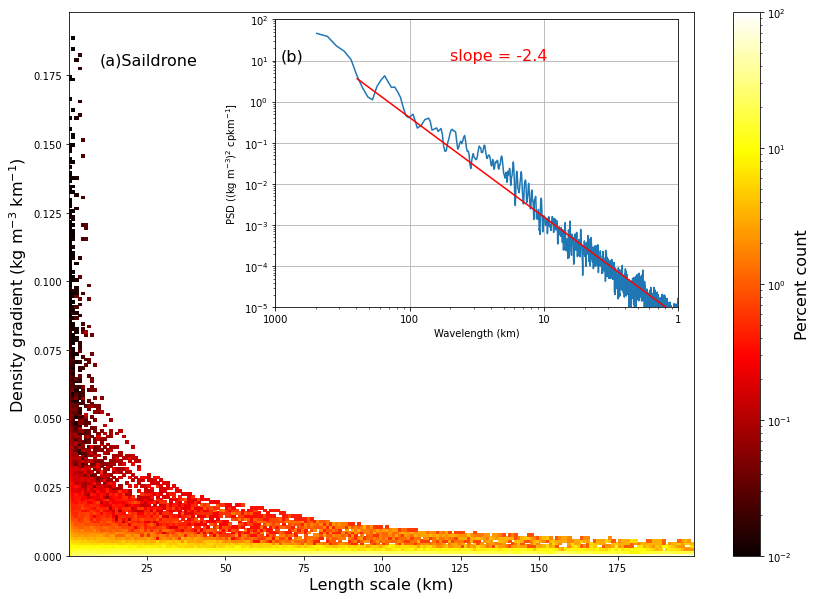

In [6]:
psd_fig(freq2_usv,ddn_usv,Pxx_den_welch_usv,'Saildrone','PSD_den_grad_usv_welch.png',4000)


In [7]:
# testing slepian multitaper
#args number of points in the ouput window, width, symmetric?
M = 51 #window length
BW = 0.08
N = 66240
NW = 3.5 #half bandwidth corresponding to 2*NW = BW/f0 = BW*N*dt
Kmax = 1
window = signal.windows.dpss(M, NW, sym = True)

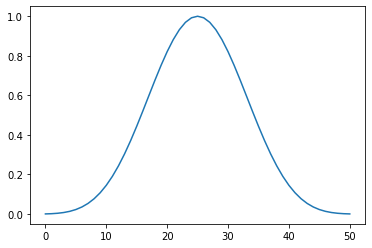

In [8]:
plt.plot(window)


In [9]:
ds

<xarray.Dataset>
Dimensions:                         (time: 66240, trajectory: 3)
Coordinates:
  * time                            (time) datetime64[ns] 2020-01-17 ... 2020...
    latitude                        (trajectory, time) float64 11.77 ... 9.193
    longitude                       (trajectory, time) float64 -56.28 ... -52.02
  * trajectory                      (trajectory) object '1026' '1060' '1061'
    dayofyear                       (trajectory, time) float64 16.0 ... 62.0
Data variables:
    SOG                             (trajectory, time) float64 2.214 ... 1.587
    SOG_FILTERED_MEAN               (trajectory, time) float64 1.894 ... 1.678
    SOG_FILTERED_STDDEV             (trajectory, time) float64 0.251 ... 0.299
    SOG_FILTERED_MAX                (trajectory, time) float64 2.597 ... 2.539
    SOG_FILTERED_MIN                (trajectory, time) float64 1.465 ... 1.027
    COG                             (trajectory, time) float64 153.7 ... 318.1
    COG_FILTERED_MEAN               (trajectory, time) float64 160.0 ... 318.8
    COG_FILTERED_STDDEV             (trajectory, time) float64 12.3 ... 14.1
    HDG                             (trajectory, time) float64 152.0 ... 311.9
    HDG_FILTERED_MEAN               (trajectory, time) float64 148.3 ... 310.2
    HDG_FILTERED_STDDEV             (trajectory, time) float64 0.0 0.0 ... 0.0
    ROLL_FILTERED_MEAN              (trajectory, time) float64 11.9 -2.8 ... 2.9
    ROLL_FILTERED_STDDEV            (trajectory, time) float64 0.0 0.0 ... 0.0
    ROLL_FILTERED_PEAK              (trajectory, time) float64 11.9 -2.8 ... 2.9
    PITCH_FILTERED_MEAN             (trajectory, time) float64 9.3 -1.0 ... -3.2
    PITCH_FILTERED_STDDEV           (trajectory, time) float64 0.0 0.0 ... 0.0
    PITCH_FILTERED_PEAK             (trajectory, time) float64 9.3 -1.0 ... -3.2
    HDG_WING                        (trajectory, time) float64 103.3 ... 51.7
    WING_HDG_FILTERED_MEAN          (trajectory, time) float64 99.6 ... 52.5
    WING_HDG_FILTERED_STDDEV        (trajectory, time) float64 3.8 4.7 ... 4.5
    WING_ROLL_FILTERED_MEAN         (trajectory, time) float64 3.3 3.6 ... 0.0
    WING_ROLL_FILTERED_STDDEV       (trajectory, time) float64 3.4 4.8 ... 3.1
    WING_ROLL_FILTERED_PEAK         (trajectory, time) float64 nan nan ... nan
    WING_PITCH_FILTERED_MEAN        (trajectory, time) float64 3.7 3.7 ... 1.0
    WING_PITCH_FILTERED_STDDEV      (trajectory, time) float64 5.3 4.4 ... 6.9
    WING_PITCH_FILTERED_PEAK        (trajectory, time) float64 15.8 ... 19.5
    WING_ANGLE                      (trajectory, time) float64 -48.8 ... 99.9
    UWND_MEAN                       (trajectory, time) float64 -8.51 ... -7.47
    UWND_STDDEV                     (trajectory, time) float64 0.61 0.6 ... 0.51
    VWND_MEAN                       (trajectory, time) float64 -1.83 ... -1.53
    VWND_STDDEV                     (trajectory, time) float64 0.59 ... 0.48
    WWND_MEAN                       (trajectory, time) float64 -0.1 ... -0.12
    WWND_STDDEV                     (trajectory, time) float64 0.32 ... 0.33
    GUST_WND_MEAN                   (trajectory, time) float64 9.7 8.82 ... 8.36
    GUST_WND_STDDEV                 (trajectory, time) float64 0.5 0.48 ... 0.36
    WIND_MEASUREMENT_HEIGHT_MEAN    (trajectory, time) float64 4.947 ... 4.946
    WIND_MEASUREMENT_HEIGHT_STDDEV  (trajectory, time) float64 0.059 ... 0.06
    TEMP_AIR_MEAN                   (trajectory, time) float64 26.98 ... 26.12
    TEMP_AIR_STDDEV                 (trajectory, time) float64 0.03 ... 0.04
    RH_MEAN                         (trajectory, time) float64 79.77 ... 78.45
    RH_STDDEV                       (trajectory, time) float64 0.49 ... 0.46
    BARO_PRES_MEAN                  (trajectory, time) float64 1.016e+03 ... ...
    BARO_PRES_STDDEV                (trajectory, time) float64 0.06 ... 0.06
    PAR_AIR_MEAN                    (trajectory, time) float64 0.0 0.0 ... 0.0
    PAR_AIR_STDDEV    

In [10]:
data_in = ds
ds_usv = data_in.isel(trajectory=iusv)
ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
ds3 = ds2.swap_dims({'time':'dist_total'})
dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],0.08)
ds4 = ds3.interp(dist_total=dist_interp)
den = ds4.density_mean.interpolate_na(dim='dist_total')
den = den.where(np.isfinite(den),drop=True)
ds4_detrend = signal.detrend(den)
ds4_detrend_smooth = ds4_detrend


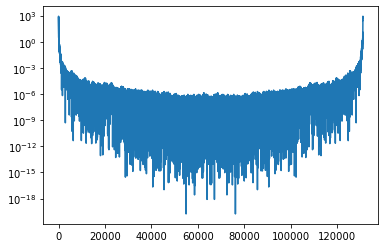

In [11]:
data = ds4_detrend_smooth
#[tapers, eigen] = dpss(71465, 3.5, 4)
#res = pmtm(data, e=eigen, v=tapers, show=True)
# You do not need to compute the DPSS before end
#res = pmtm(data, NW=2.5, show=False)
sk,w,e = pmtm(data, NW=2.5, k=4, show=True)


In [15]:
from pylab import semilogy
sk = np.mean(sk * w, axis=0)
semilogy(sk)

ValueError: operands could not be broadcast together with shapes (131072,) (131072,4) 

In [16]:
istart,iend=5,5550
plt.loglog([0:], Pxx_den[istart:iend])


NameError: name 'f' is not defined

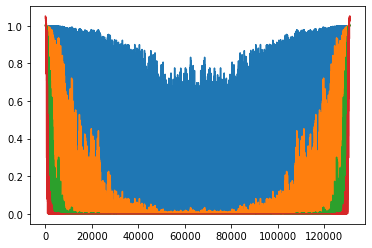

In [26]:
plt.plot(res[1])